In [1]:
import pandas as pd
import numpy as np
import os
from warnings import simplefilter

# =====================================
# 0. Config
# =====================================
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

data_folder_path = "/kaggle/input/all-network"
chunksize = 100_000

cols_to_drop_early = ['Flow ID', 'Timestamp', 'Src IP', 'Dst IP', 'Malware_Sample']

# =====================================
# 1. Load nhiều file CSV theo chunk
# =====================================
csv_files = [f for f in os.listdir(data_folder_path) if f.endswith('.csv')]
print(f"Tìm thấy {len(csv_files)} file CSV:", csv_files)

chunks_list = []
total_rows = 0

for file in csv_files:
    file_path = os.path.join(data_folder_path, file)
    print(f"\nĐang đọc file: {file}")

    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
        
        # Clean column names
        chunk.columns = chunk.columns.str.strip()

        # Drop cột rác sớm
        drop_exist = [c for c in cols_to_drop_early if c in chunk.columns]
        if drop_exist:
            chunk = chunk.drop(columns=drop_exist)

        chunks_list.append(chunk)
        total_rows += len(chunk)

print(f"\nĐã đọc xong {total_rows} dòng. Đang ghép dữ liệu...")

df = pd.concat(chunks_list, ignore_index=True)
del chunks_list

print("Initial shape after merge:", df.shape)

# =====================================
# 2. Remove duplicates
# =====================================
before_dupes = df.shape[0]
df = df.drop_duplicates()
print(f"Removed {before_dupes - df.shape[0]} duplicate rows")

# =====================================
# 3. Tách Label (GIỮ NHÃN CHỮ)
# =====================================
label = df["Label"].copy()
df = df.drop(columns=["Label"], errors="ignore")

# =====================================
# 4. Convert numeric
# =====================================
df = df.apply(pd.to_numeric, errors="coerce")

# =====================================
# 5. Xử lý Inf
# =====================================
df = df.replace([np.inf, -np.inf], np.nan)

# =====================================
# 6. Drop cột toàn NaN
# =====================================
nan_cols = df.columns[df.isna().all()].tolist()
df = df.drop(columns=nan_cols)
print("Removed NaN-only cols:", nan_cols)

# =====================================
# 7. Drop zero-variance columns
# =====================================
zero_var_cols = df.columns[df.std(numeric_only=True) == 0].tolist()
df = df.drop(columns=zero_var_cols)
print("Removed zero-variance cols:", zero_var_cols)

# =====================================
# 8. Fill missing bằng median
# =====================================
df = df.fillna(df.median(numeric_only=True))
print("Remaining NaN:", df.isna().sum().sum())

# =====================================
# 9. LOG TRANSFORM AN TOÀN
#    (chỉ feature không âm)
# =====================================
features = df.copy()

non_negative_cols = features.columns[(features.min() >= 0)]
signed_cols = features.columns[(features.min() < 0)]

print(f"Non-negative features for log: {len(non_negative_cols)}")
print(f"Signed (negative) features kept raw: {len(signed_cols)}")

features[non_negative_cols] = np.log1p(features[non_negative_cols])

print("\nAfter safe log:")
print("Logged features min:", features[non_negative_cols].min().min())
print("Logged features max:", features[non_negative_cols].max().max())
print("Signed features min:", features[signed_cols].min().min())
print("Signed features max:", features[signed_cols].max().max())
print("NaN count:", features.isna().sum().sum())

# =====================================
# 10. Ép kiểu float32 (CHUẨN DL)
# =====================================
features = features.astype(np.float32)

# =====================================
# 11. Gắn lại Label
# =====================================
df = features
df["Label"] = label.values

# =====================================
# 12. Summary cuối
# =====================================
print("\n--- FINAL SUMMARY ---")
print("Final shape:", df.shape)
print(df.dtypes.value_counts())
print("\nLabel distribution:")
print(df["Label"].value_counts())


Tìm thấy 1 file CSV: ['All_Network.csv']

Đang đọc file: All_Network.csv

Đã đọc xong 2646212 dòng. Đang ghép dữ liệu...
Initial shape after merge: (2646212, 80)
Removed 8126 duplicate rows
Removed NaN-only cols: []
Removed zero-variance cols: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg']
Remaining NaN: 0
Non-negative features for log: 64
Signed (negative) features kept raw: 6

After safe log:
Logged features min: 0.0
Logged features max: 22.137053762618443
Signed features min: -31000000.0
Signed features max: 4111500000.0
NaN count: 0

--- FINAL SUMMARY ---
Final shape: (2638086, 71)
float32    70
object      1
Name: count, dtype: int64

Label distribution:
Label
Benign      2619256
Worm           3279
Trojan         2992
HackTool       2413
Exploit        2212
Virus          2188
Backdoor       2057
Hoax           1890
Rootkit        1799
Name: count, dtype: i

In [3]:
df.to_csv("cleaned-BCCC-Mal-NetMem.csv", index=False)
print("Đã lưu dataset")

Đã lưu dataset


Số lượng cụ thể:
Label
Benign      2619256
Worm           3279
Trojan         2992
HackTool       2413
Exploit        2212
Virus          2188
Backdoor       2057
Hoax           1890
Rootkit        1799
Name: count, dtype: int64


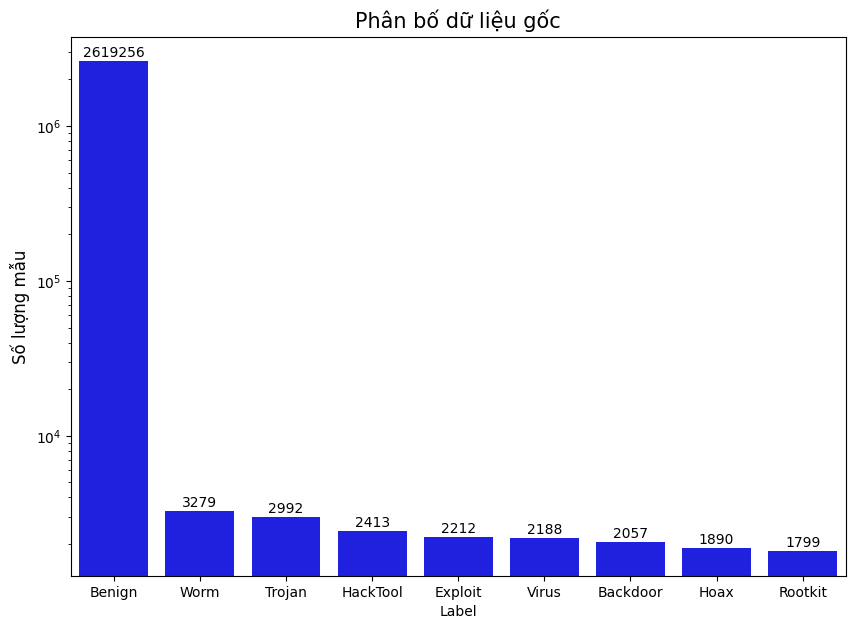

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử biến dataframe của bạn tên là final_df (hoặc data)
# Đếm số lượng
label_counts = df['Label'].value_counts()
print("Số lượng cụ thể:")
print(label_counts)

thu_tu_giam_dan = df['Label'].value_counts().index
# Thiết lập kích thước biểu đồ
plt.figure(figsize=(10, 7))

# Vẽ biểu đồ cột
# palette='viridis' để màu sắc đẹp mắt
#ax = sns.countplot(x='Label', data=final_df, color='blue')
ax = sns.countplot(x='Label', data=df, 
                   color='blue', 
                   order=thu_tu_giam_dan)
plt.yscale('log')
# --- QUAN TRỌNG: Hiển thị số liệu trên đầu cột ---
# Lệnh này tự động viết số lên (ví dụ: 7123456)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10, padding=1)

# Trang trí
plt.title('Phân bố dữ liệu gốc', fontsize=15)
#plt.xlabel('Nhãn (Label)', fontsize=12)
plt.ylabel('Số lượng mẫu', fontsize=12)

# Hiển thị
plt.savefig('phan_bo_goc.png', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
import pandas as pd
import numpy as np
from warnings import simplefilter

# ================================
# 0. Config
# ================================
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

file_path = "/kaggle/input/malware-dataset/BCCC-Mal-NetMem-Original.csv"

# ================================
# 1. Load dữ liệu
# ================================
df = pd.read_csv(file_path, low_memory=False)
print(f"1. Initial shape: {df.shape}")

# ================================
# 2. Clean column names + duplicate
# ================================
df.columns = df.columns.str.strip()

before_dupes = df.shape[0]
df = df.drop_duplicates()
print(f"2. Removed {before_dupes - df.shape[0]} duplicate rows")

# ================================
# 3. Tách label (GIỮ NHÃN CHỮ)
# ================================
label = df["Label"].copy()
df = df.drop(columns=["Label", "Timestamp"], errors="ignore")

# ================================
# 4. Convert numeric
# ================================
df = df.apply(pd.to_numeric, errors="coerce")

# ================================
# 5. Xử lý Inf
# ================================
df = df.replace([np.inf, -np.inf], np.nan)

# ================================
# 6. Drop cột toàn NaN
# ================================
nan_cols = df.columns[df.isna().all()].tolist()
df = df.drop(columns=nan_cols)
print("Removed NaN-only cols:", nan_cols)

# ================================
# 7. Drop zero-variance columns
# ================================
zero_var_cols = df.columns[df.std(numeric_only=True) == 0].tolist()
df = df.drop(columns=zero_var_cols)
print("Removed zero-variance cols:", zero_var_cols)

# ================================
# 8. Fill missing bằng median
# ================================
df = df.fillna(df.median(numeric_only=True))
print("Remaining NaN:", df.isna().sum().sum())

# =====================================================
# 9. LOG TRANSFORM AN TOÀN (CHỈ FEATURE ≥ 0)
# =====================================================
features = df.copy()

non_negative_cols = features.columns[(features.min() >= 0)]
signed_cols = features.columns[(features.min() < 0)]

print(f"Non-negative features for log: {len(non_negative_cols)}")
print(f"Signed (negative) features kept raw: {len(signed_cols)}")

features[non_negative_cols] = np.log1p(features[non_negative_cols])

print("After safe log:")
print("Logged features min:", features[non_negative_cols].min().min())
print("Logged features max:", features[non_negative_cols].max().max())
print("Signed features min:", features[signed_cols].min().min())
print("Signed features max:", features[signed_cols].max().max())
print("NaN count:", features.isna().sum().sum())

# ================================
# 10. Gắn lại label (NHÃN CHỮ)
# ================================
df = features
df["Label"] = label.values

# ================================
# 11. Summary
# ================================
print("\n--- Final Summary ---")
print("Final shape:", df.shape)
print(df.dtypes.value_counts())


1. Initial shape: (2644335, 80)
2. Removed 8114 duplicate rows
Removed NaN-only cols: []
Removed zero-variance cols: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg']
Remaining NaN: 0
Non-negative features for log: 64
Signed (negative) features kept raw: 6
After safe log:
Min: -31000000.0
Max: 4111500000.0
NaN count: 0

--- Final Summary ---
Final shape: (2636221, 71)
float64    69
int64       1
object      1
Name: count, dtype: int64


In [9]:
print(df["Label"].value_counts())

Label
Benign      2617391
Worm           3279
Trojan         2992
HackTool       2413
Exploit        2212
Virus          2188
Backdoor       2057
Hoax           1890
Rootkit        1799
Name: count, dtype: int64


In [10]:
df.to_csv("cleaned-BCCC-Mal-NetMem_V2.csv", index=False)
print("Cleaned and Encoded sample saved")

Cleaned and Encoded sample saved


In [ ]:
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# -----------------------------------------
# 1) Load dữ liệu parquet đã cleaning sẵn
# -----------------------------------------

# files = glob.glob("/kaggle/input/cleaned-10-dataset/cleaned_10_dataset_v1.csv")

# # skip_files = [
# #     "/kaggle/input/cse-cic-ids2018-1/DoS1-Thursday-15-02-2018_TrafficForML_CICFlowMeter.parquet",
# #     "/kaggle/input/cse-cic-ids2018-1/DoS2-Friday-16-02-2018_TrafficForML_CICFlowMeter.parquet",
# #     "/kaggle/input/cse-cic-ids2018-1/Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter.parquet"
# # ]

# #files = [f for f in files if not any(s in f for s in skip_files)]

# #print("Số file còn lại:", len(files))

# df_list = []
# for f in files:
#     print("Đang đọc:", f)
#     tmp = pd.read_csv(f)
#     df_list.append(tmp)
df = pd.read_csv("/kaggle/input/cleaned-cicids2018/cleaned_CICIDS2018.csv")
#df = pd.concat(file, ignore_index=True)
print("Kích thước ban đầu:", df.shape)

class_counts = df["Label"].value_counts()
class_percent = df['Label'].value_counts(normalize=True) * 100
print("Class distribution:")
print(pd.DataFrame({'Count': class_counts, 'Percentage': class_percent.round(4)}))

# -----------------------------------------
#2) Mã hóa Label (không đổi data khác)
#-----------------------------------------
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])

print("\nPhân bố nhãn:")
print(df["Label"].value_counts())

mapping_group = {
    0: "Benign",
    1: "Botnet",
    4: "DoS/DDoS",
    5: "DoS/DDoS",
    6: "DoS/DDoS",
    7: "DoS/DDoS",
    8: "DoS/DDoS",
    9: "DoS/DDoS",
    10: "DoS/DDoS",
    2: "Web Attack",
    3: "Web Attack",
    13: "Web Attack",
    11: "Brute Force",
    14: "Brute Force",
    12: "Infiltration"
}

df["Label_Grouped"] = df["Label"].map(mapping_group)

X = df.drop(["Label", "Label_Grouped"], axis=1)
y = df["Label_Grouped"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Thứ tự nhãn: ", dict(zip(le.classes_, le.transform(le.classes_))))

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)
print(train_df.shape)
print(test_df.shape)

In [ ]:
train_df.to_csv("train_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

print("Đã lưu train.csv và test.csv")

In [ ]:
# Phân bố lớp được lấy từ EDA
class_percentages = {
    'Benign': 83.069712,
    'DDOS attack-HOIC': 4.22633,
    'DDoS attacks-LOIC-HTTP': 3.549504,
    'DoS attacks-Hulk': 2.845512,
    'Bot': 1.763020,
    'FTP-BruteForce': 1.191154,
    'SSH-Bruteforce': 1.155603,
    'Infilteration': 0.997560,
    'DoS attacks-SlowHTTPTest': 0.861763,
    'DoS attacks-GoldenEye': 0.255701,
    'DoS attacks-Slowloris': 0.067702,
    'DDOS attack-LOIC-UDP': 0.010657,
    'Brute Force -Web': 0.003764,
    'Brute Force -XSS': 0.001417,
    'SQL Injection': 0.000536
}
# Kích thước mẫu mục tiêu (10% của toàn bộ tập dữ liệu)
# target_sample_size = 1623300
# target_per_class = {label: int(p / 100 * target_sample_size) for label, p in class_percentages.items()}
# collected = {label: [] for label in class_percentages}

# # Đọc và lấy mẫu theo lớp
# # Sử dụng pd.read_csv với chunksize để đọc file lớn

# print("Bắt đầu đọc từng file và lấy mẫu...")

# for filename in csv_files:
#     file_path = os.path.join(data_folder_path, filename)
#     print(f"\n--- Xử lý file: {filename} ---")
#     for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
#         for label in class_percentages:
#         # Lấy các hàng thuộc về lớp hiện tại trong chunk
#             rows = chunk[chunk['Label'] == label]
        
#         # Số lượng mẫu còn cần lấy cho lớp này
#             needed = target_per_class[label] - sum(len(x) for x in collected[label])
        
#         # Nếu vẫn còn cần và có hàng trong chunk
#             if needed > 0 and not rows.empty:
#             # Lấy mẫu ngẫu nhiên từ các hàng có sẵn, giới hạn bởi số lượng còn cần
#                 sampled = rows.sample(n=min(len(rows), needed), random_state=42)
#             # Thêm mẫu đã lấy vào danh sách thu thập
#                 collected[label].append(sampled)

# # Kết hợp và xáo trộn mẫu
# print("Kết hợp và xáo trộn mẫu...")
# # Bước 1: Kết hợp tất cả các DataFrame trong mỗi danh sách collected[label]
# # Bước 2: Kết hợp tất cả các lớp đã kết hợp lại thành sample_df
# sample_df = pd.concat([pd.concat(v) for v in collected.values()], ignore_index=True)

# # Xáo trộn toàn bộ DataFrame (frac=1)
# sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)

# print("Hoàn thành việc lấy mẫu.")
# print(f"Kích thước DataFrame mẫu cuối cùng: {len(sample_df)}")
# print("\nPhân bố lớp của mẫu cuối cùng:")
# print(sample_df['Label'].value_counts())
